In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(tsibble, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
# library(forcats, warn.conflicts = FALSE)
library(arrow, warn.conflicts = FALSE)
# library(data.table, warn.conflicts = FALSE)
# library(dtplyr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(lubridate, warn.conflicts = FALSE)
source("src/paths/paths.R")
# source("src/load/load.R")
# source("src/pairing/utils.R")


In [2]:
path.lom <- file.path(path.ds, "ARPA", "LOMBARDIA")
path.md <- file.path(path.lom, "Stazioni_Meteorologiche.tsv")

metadata <- read_tsv_arrow(path.md,
    col_types = schema(
        IdSensore = uint32(),
        IdStazione = uint32(),
        NomeStazione = utf8(),
        Tipologia = dictionary(),
        Provincia = dictionary(),
        DataStart = timestamp(unit = "s"),
        DataStop = timestamp(unit = "s"),
        Quota = float(),
        lng = float(),
        lat = float()
    ),
    timestamp_parsers = "%d/%m/%Y",
    as_data_frame = FALSE,
    col_select = c("IdSensore", "IdStazione", "NomeStazione", "Tipologia", "Provincia", "DataStart", "DataStop", "Quota", "lng", "lat")
) |>
    filter(Tipologia == "Temperatura") |>
    select(-Tipologia) |>
    mutate(across(starts_with("Data"), ~ cast(., date32())))
# filter(Tipologia == "Temperatura") |>
# select(!c(Tipologia, starts_with("UTM"), ends_with("Misura"), location, Storico)) |>
# mutate(DataStart = as.IDate(DataStart, format = "%d/%m/%Y"), DataStop = as.IDate(DataStop, format = "%d/%m/%Y"))


In [3]:
na_strings <- c("", "NA", "9999.0", "-9999.0", "-9999", "NV", "NC", "ND")

csv_schema <- schema(
    IdSensore = uint32(),
    Data = timestamp(unit = "s"),
    Valore = float32(),
    Stato = utf8(),
    idOperatore = uint8()
)
csv_parsers <- c("%d/%m/%Y %H:%M:%S", "%d/%m/%Y %H:%M:%S.000")

open_orig_ds <- function() {
    open_csv_dataset(fs::dir_ls(path.lom, glob = "*.csv"),
        hive_style = FALSE,
        schema = csv_schema,
        timestamp_parsers = csv_parsers,
        na = na_strings,
        col_names = TRUE,
        skip = 1
    ) |>
        semi_join(metadata, by = "IdSensore") |>
        mutate(Data = Data - lubridate::minutes(10))
}

edit_orig_ds <- function(table) {
    table |>
        collect() |>
        arrange(IdSensore, idOperatore, Data) |>
        group_by(IdSensore, idOperatore) |>
        mutate(Time = lag(Data), .keep = "unused") |>
        ungroup() |>
        drop_na(Time)
}

write_lagged_ds <- function(table) {
    table |>
        as_arrow_table(schema = schema(
            IdSensore = uint32(),
            Valore = float32(),
            Stato = utf8(),
            idOperatore = uint8(),
            Time = timestamp(unit = "s"),
        )) |>
        write_dataset(file.path(path.lom, "lagged_dataset"),
            format = "ipc",
            partitioning = "IdSensore"
        )
}

read_year <- function(name) {
    read_csv_arrow(file.path(path.lom, paste0(name, ".csv")),
        schema = csv_schema,
        timestamp_parsers = csv_parsers,
        as_data_frame = FALSE,
        skip = 1
    ) |> semi_join(metadata, by = "IdSensore")
}

open_lom_dataset <- function() {
    open_dataset(file.path(path.lom, "lagged_dataset"),
        format = "ipc",
        partitioning = "IdSensore"
    )
}

compute_daily_stats <- function(ds) {
    ds |>
        group_by(IdSensore, Date = lubridate::date(Time)) |>
        summarise(T_MIN = min(Valore, na.rm = TRUE), T_MAX = max(Valore, na.rm = TRUE), .groups = "drop_last")
}


In [4]:
open_orig_ds()

ERROR while rich displaying an object: Error in `map_chr()`:
i In index: 2.
i With name: Data.
Caused by error:
! NotImplemented: Function 'subtract_checked' has no kernel matching input types (timestamp[s], <Period[0]>)

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw

In [28]:
data <- open_orig_ds() |>
    group_by(IdSensore, Giorno = lubridate::date(Data)) |>
    summarise(T_MIN = min(Valore, na.rm = TRUE), T_MAX = max(Valore, na.rm = TRUE)) |>
    collect()


In [ ]:
data <- data |>
    group_by(IdSensore, mth = yearmonth(Giorno)) |>
    summarise(across(starts_with("T"), ~ mean(., na.rm = TRUE))) |>
    pivot_longer(c(T_MIN, T_MAX), names_to = "Variable")


In [96]:
open_lom_dataset() |>
    compute_daily_stats() |>
    write_parquet(
        file.path(path.lom, "lombardia_daily_unchecked.parquet")
    )


In [50]:
monthly_data <- ds |>
    compute_daily_stats() |>
    collect() |>
    group_by(IdSensore, mth = yearmonth(Date)) |>
    summarise(across(starts_with("T"), ~ mean(., na.rm = TRUE))) |>
    pivot_longer(c(T_MIN, T_MAX), names_to = "Variable") |>
    mutate(Variable = as.factor(Variable))


`summarise()` has grouped output by 'IdSensore'. You can override using the
`.groups` argument.


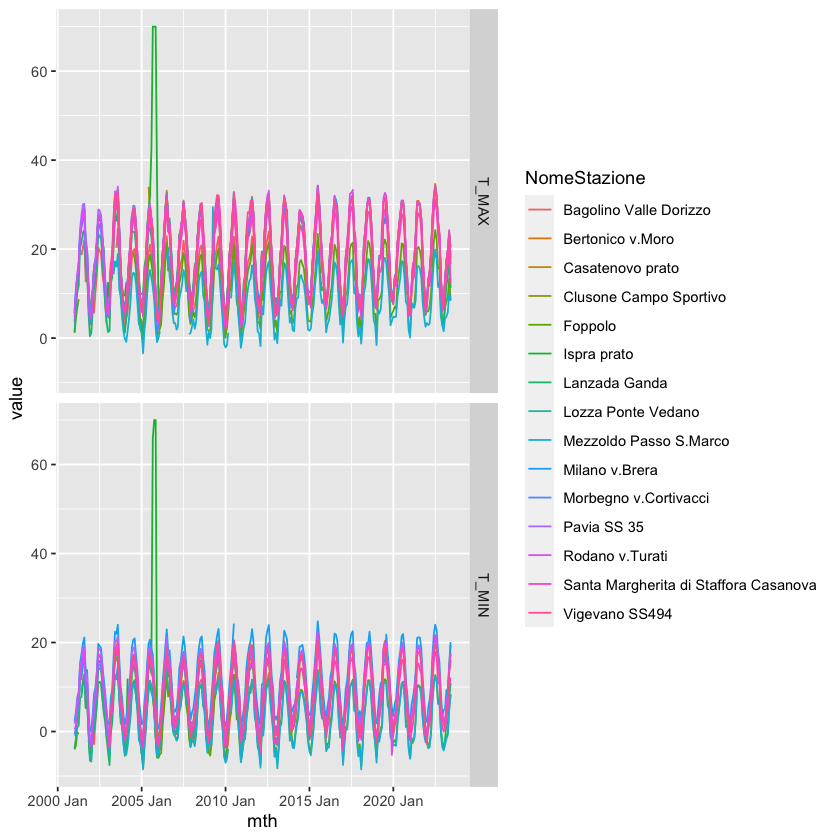

In [94]:
monthly_data |>
    as_tsibble(key = c(IdSensore, Variable), index = mth) |>
    fill_gaps() |>
    semi_join(metadata |> collect() |> sample_n(size = 15), by = "IdSensore") |>
    left_join(metadata |> collect(), by = "IdSensore") |>
    ggplot(aes(mth, value, color = NomeStazione)) +
    geom_line(na.rm = TRUE) +
    facet_grid(Variable ~ .)


In [9]:
source("src/analysis/data/clim_availability.R")
lomb_daily <- read_parquet(file.path(path.lom, "lombardia_daily_unchecked.parquet")) |>
    as_tsibble(index = Date, key = IdSensore) |>
    fill_gaps(.full = TRUE, .start = as.Date("2001-01-01"), .end = as.Date("2023-06-01"))


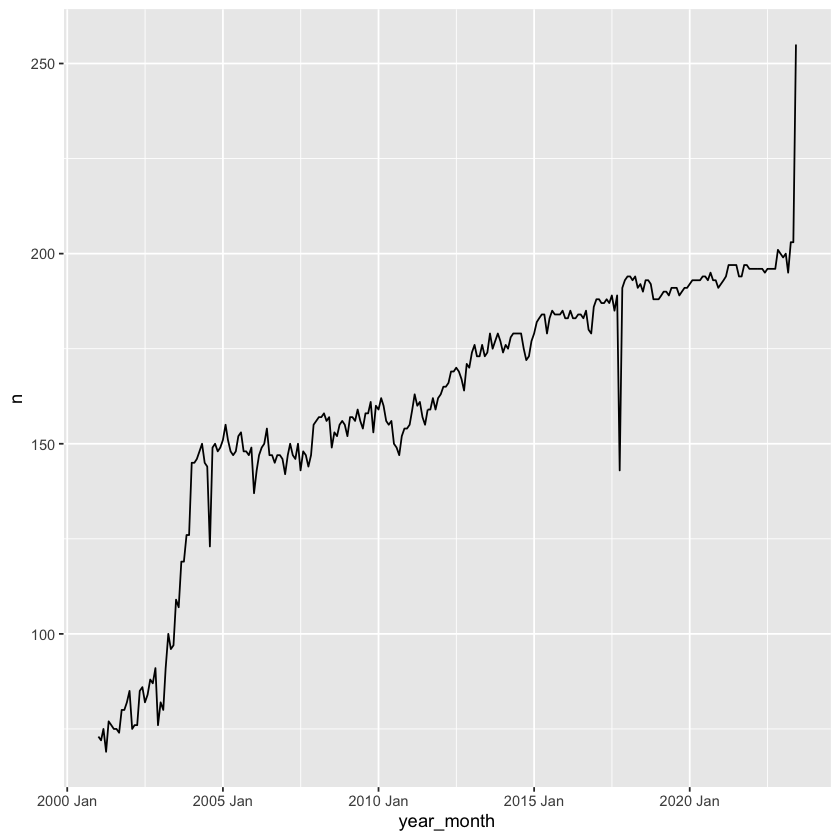

In [12]:
lomb_daily |>
    group_by_key() |>
    is_month_usable("T_MIN") |>
    summarise(n = sum(available)) |>
    ggplot(aes(year_month, n)) +
    geom_line()


Joining with `by = join_by(IdSensore)`


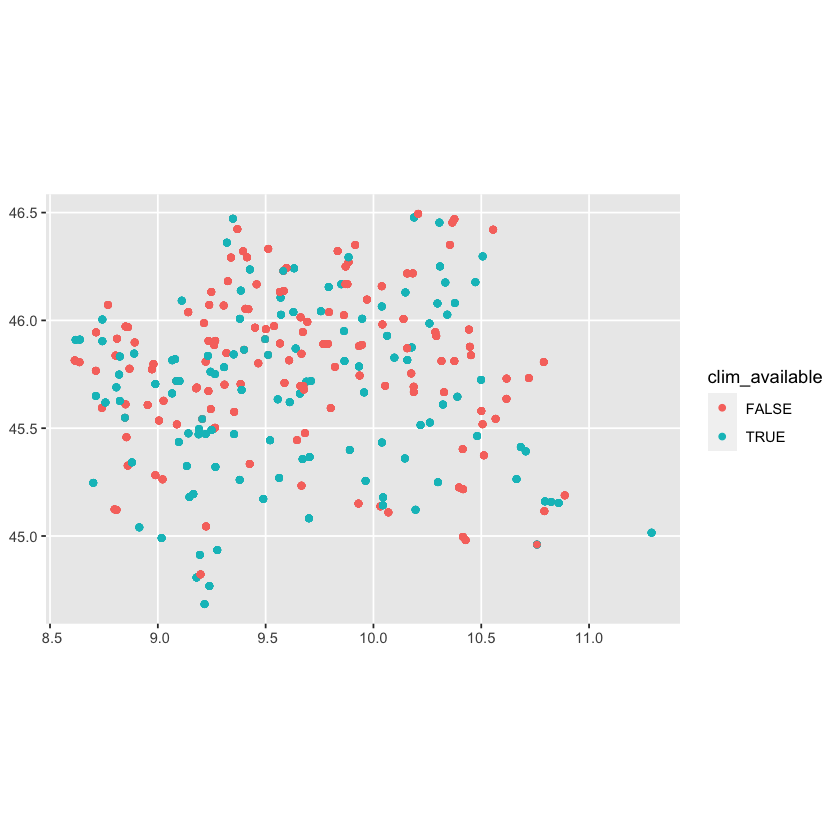

In [32]:
library(sf, warn.conflicts = FALSE)
lomb_daily |>
    rename(date = Date) |>
    group_by_key() |>
    is_climatology_computable("T_MIN", .start = as.Date("2005-01-01"), .end = as.Date("2023-01-01")) |>
    left_join(metadata |> collect()) |> st_as_sf(coords = c("lng", "lat")) |>
    ggplot() + geom_sf(aes(color = clim_available))